In [1]:
from pathlib import Path
import sys


here = Path.cwd()
candidates = [here] + list(here.parents)
for p in candidates:
    if (p / "Code").is_dir():
        sys.path.insert(0, str(p))
        break
else:
    raise RuntimeError("Couldn't find a 'Code' folder in this project.")


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd


from Code.PINN import create_network_model, u, compute_loss, g_trial_tf, make_train_step, compute_MSE
from Code.functions import euler, analytical_u


import seaborn as sns 
sns.set_theme(style="white", font_scale=1.3)
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["figure.dpi"] = 200
plt.rcParams.update({
    "savefig.dpi": 200,
    "savefig.bbox": "tight"
})


import random
def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(1)

In [2]:
dx1 = 0.1
dt1 = 0.005        # stability limit: dt = dx^2 / 2 = 0.005
x1, t1, U1 = euler(dx1, dt1, T=0.4)

# Case 2: dx = 0.01
dx2 = 0.01
dt2 = 5e-5         # stability limit: dt = dx^2 / 2 = 5e-5
x2, t2, U2 = euler(dx2, dt2, T=0.4)

In [ ]:
t1_val, t2_val = 0.01, 0.1 # find indices for these times


n1_1 = np.argmin(np.abs(t1 - t1_val))
n2_1 = np.argmin(np.abs(t1 - t2_val)) 

n1_2 = np.argmin(np.abs(t2 - t1_val))
n2_2 = np.argmin(np.abs(t2 - t2_val))


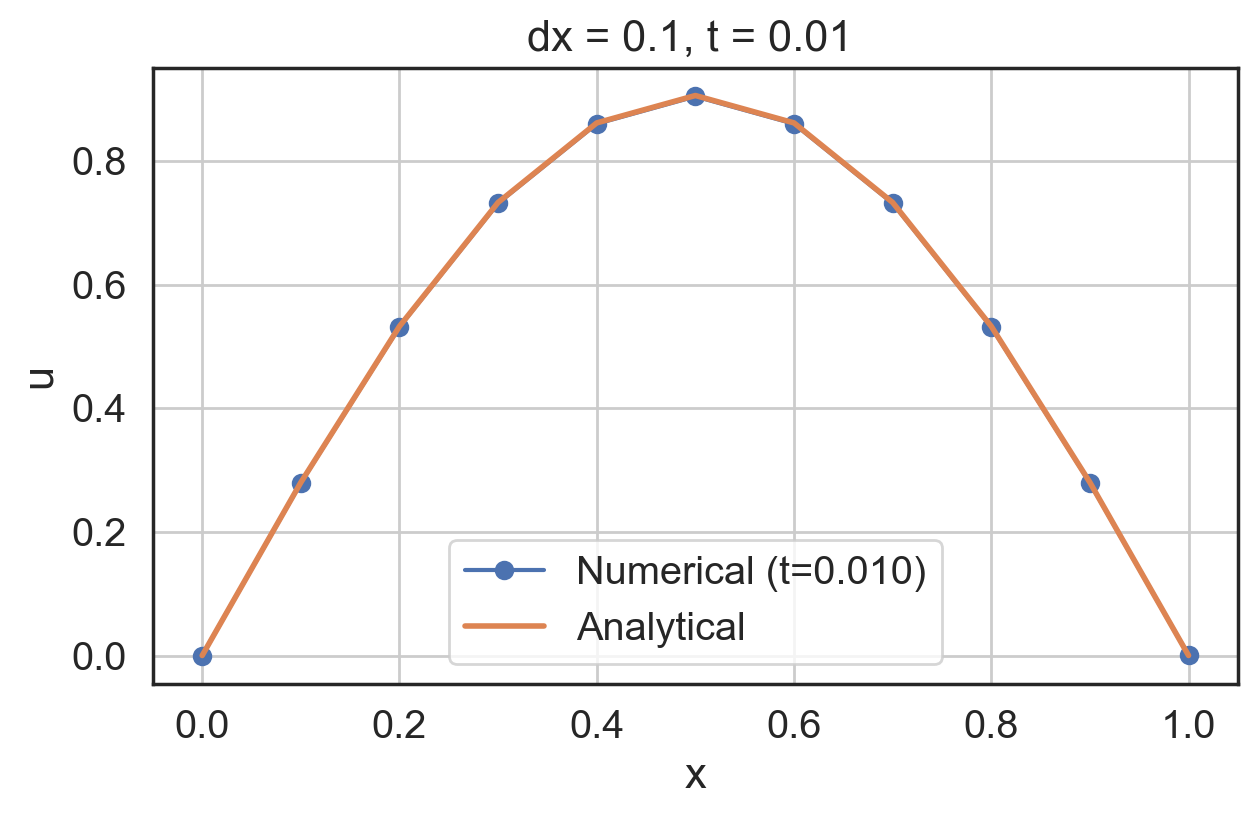

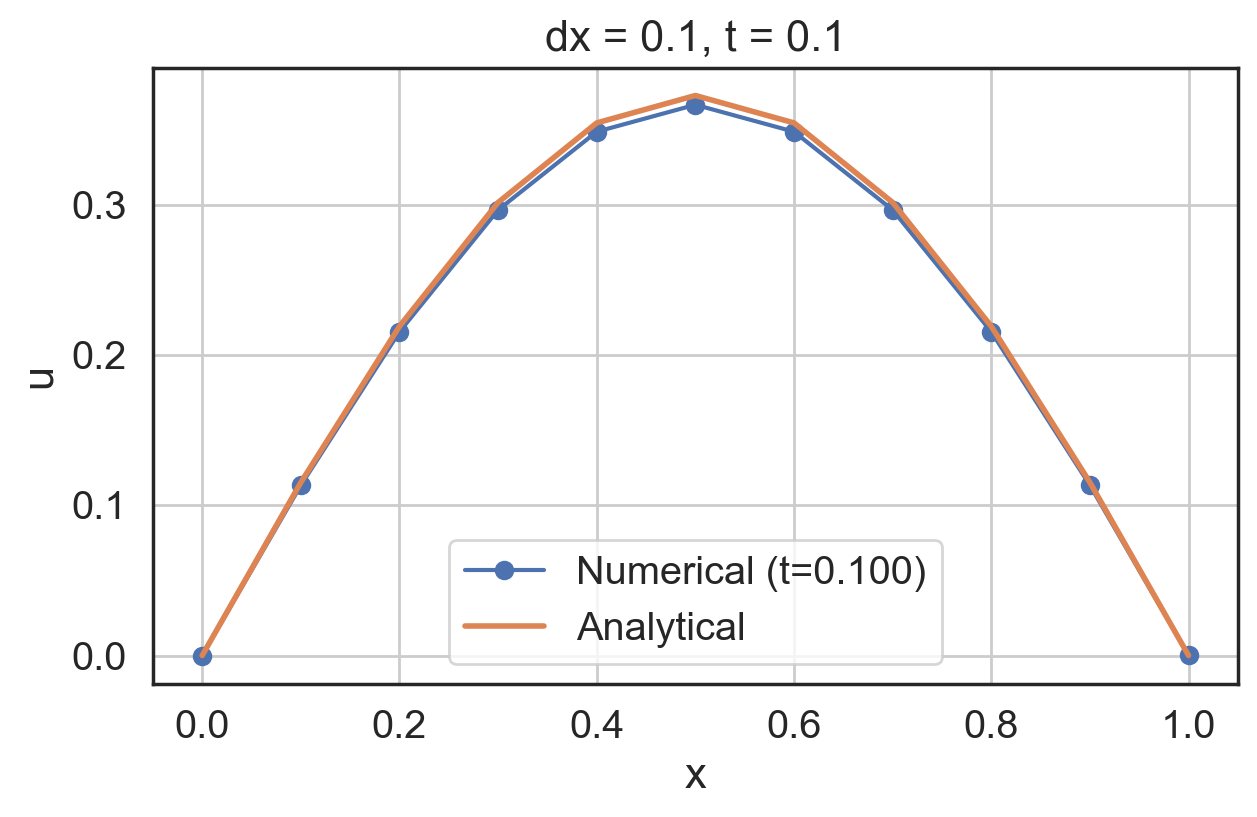

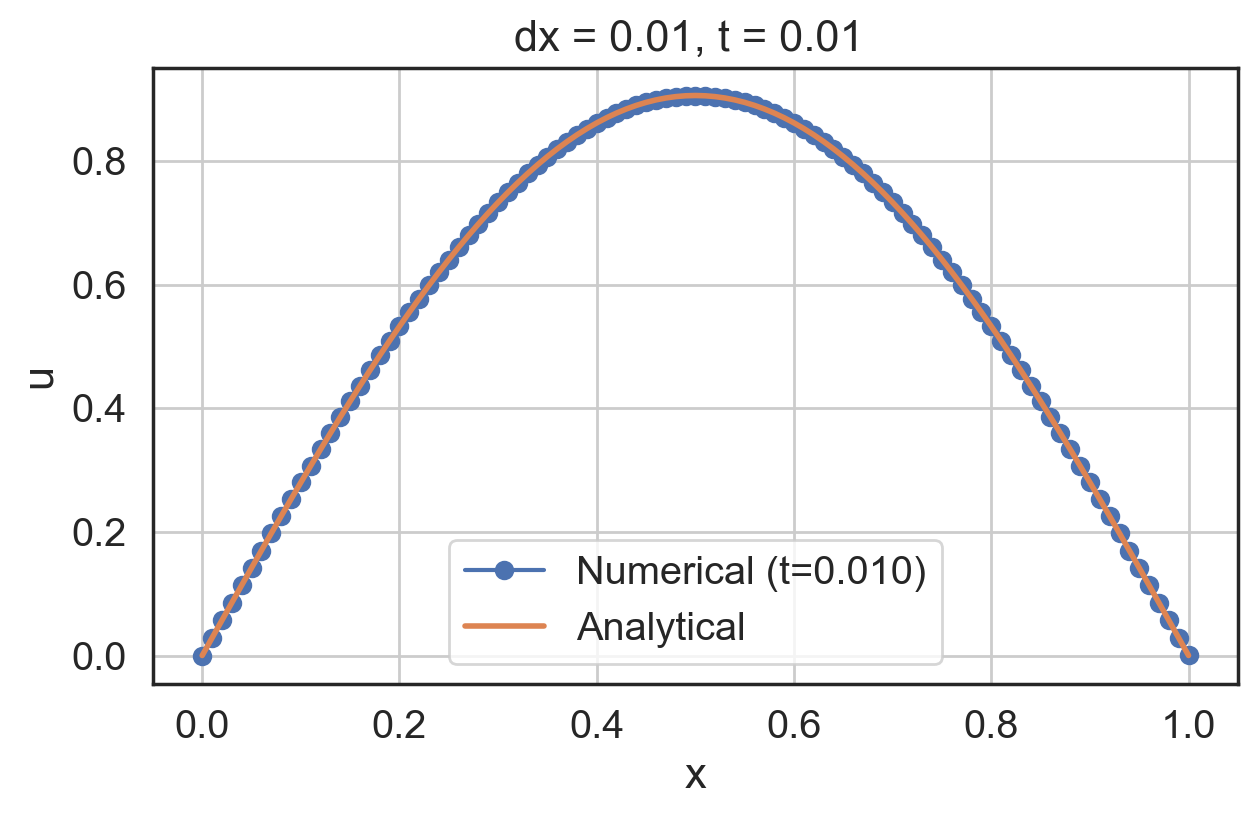

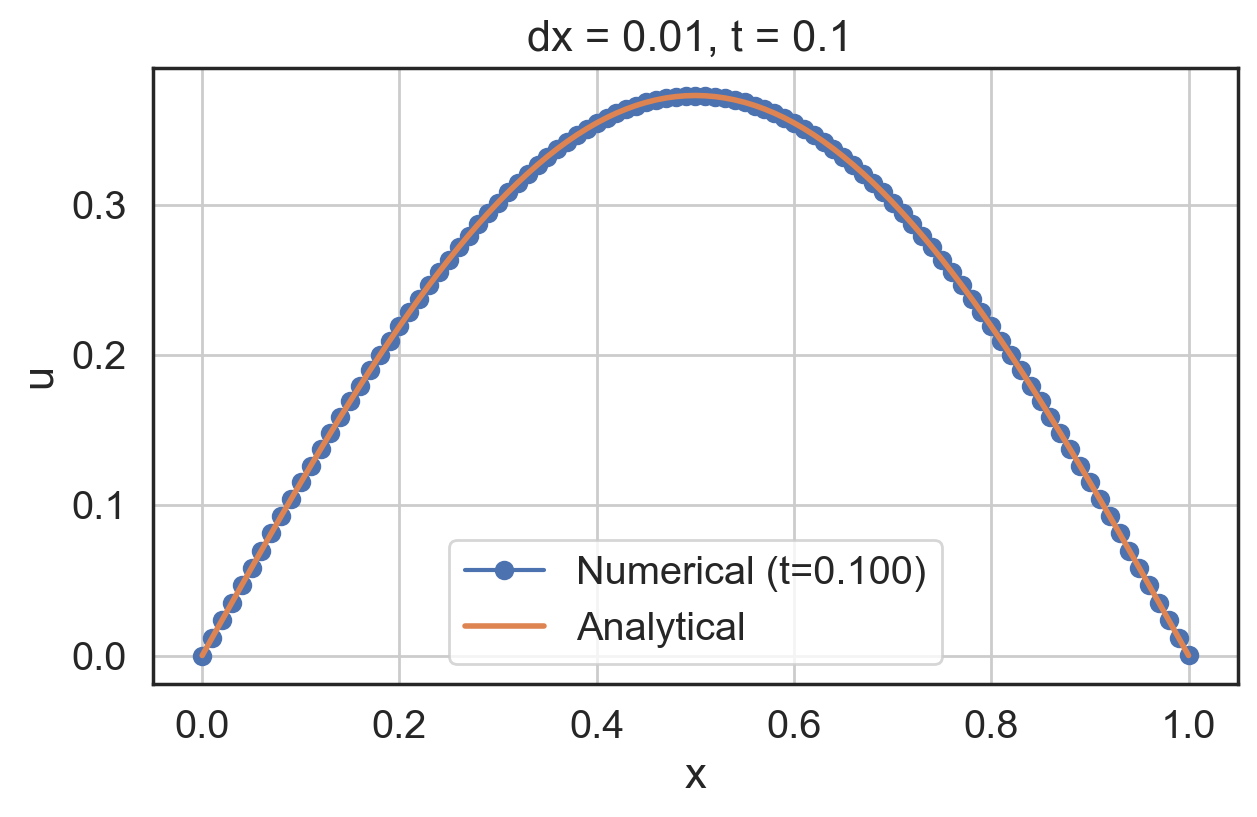

In [ ]:
def plot_comparison(x, U, t_grid, n_idx, title):
    t_val = t_grid[n_idx]
    u_num = U[n_idx]
    u_exact = analytical_u(x, t_val)

    plt.figure(figsize=(7,4))
    plt.plot(x, u_num, 'o-', label=f"Numerical (t={t_val:.3f})")
    plt.plot(x, u_exact, '-', label="Analytical", lw=2)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot comparisons for dx = 0.1
plot_comparison(x1, U1, t1, n1_1, f"dx = {dx1}, t = {t1_val} ")
plot_comparison(x1, U1, t1, n2_1, f"dx = {dx1}, t = {t2_val}")

# Plot comparisons for dx = 0.01
plot_comparison(x2, U2, t2, n1_2, f"dx = {dx2}, t = {t1_val} ")
plot_comparison(x2, U2, t2, n2_2, f"dx = {dx2}, t = {t2_val} ")

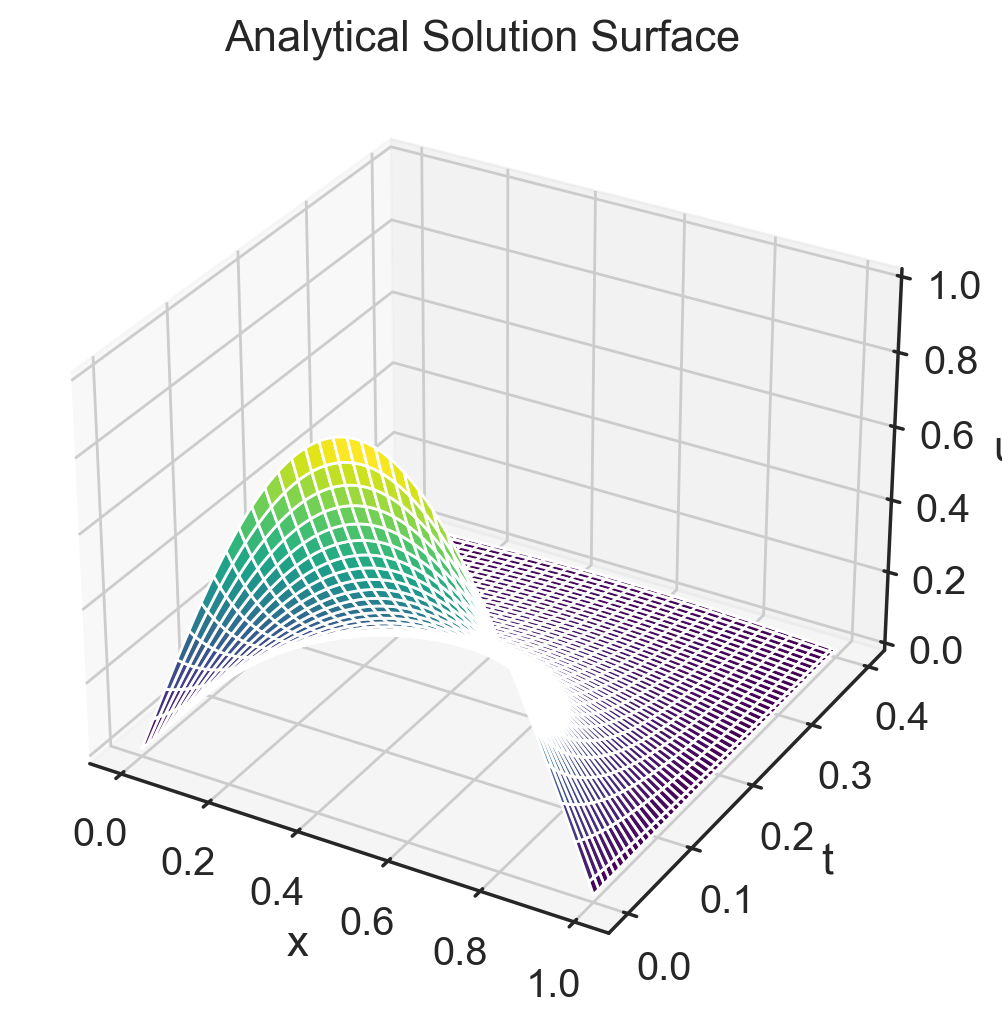

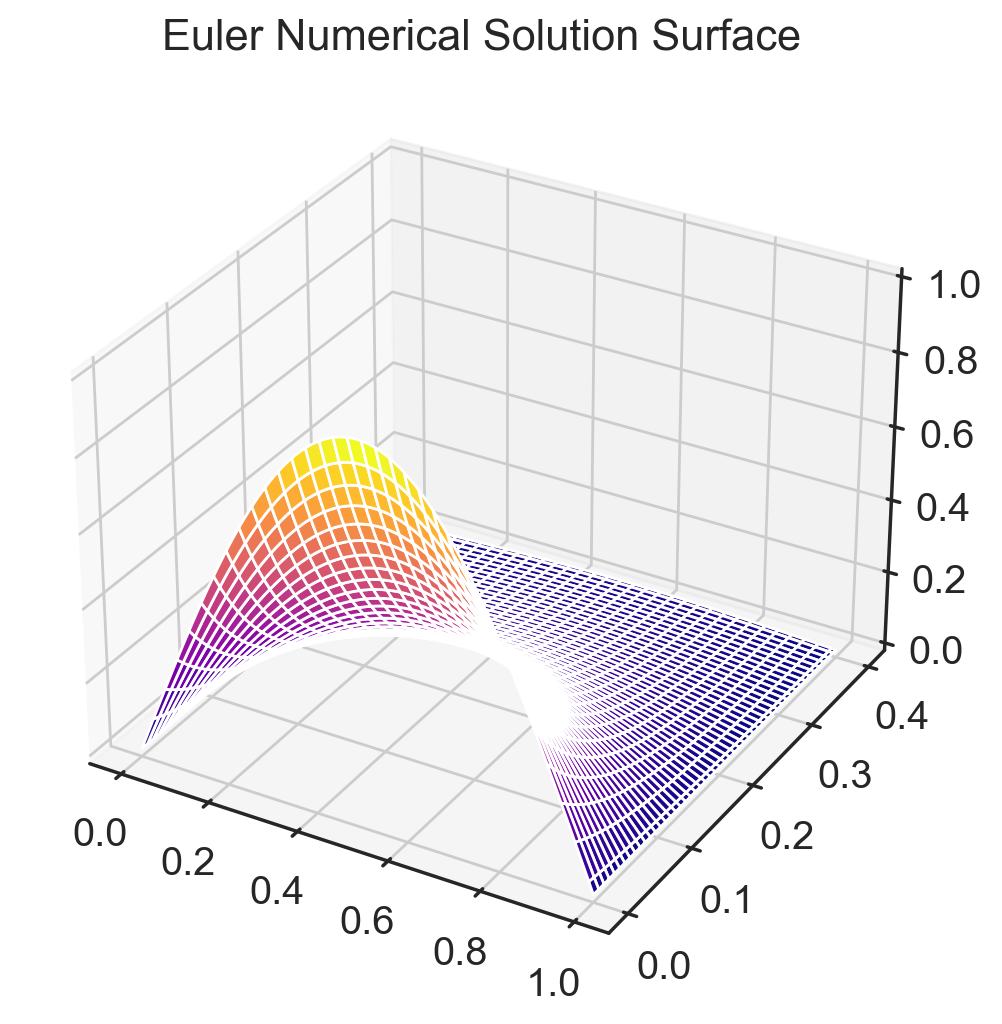

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Make a meshgrid
X, T = np.meshgrid(x2, t2)

# Analytical
U_exact = analytical_u(X, T)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, T, U_exact, cmap='viridis')
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")
ax.set_title("Analytical Solution Surface")
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U_exact, cmap='plasma')
ax.set_title("Euler Numerical Solution Surface")
plt.show()


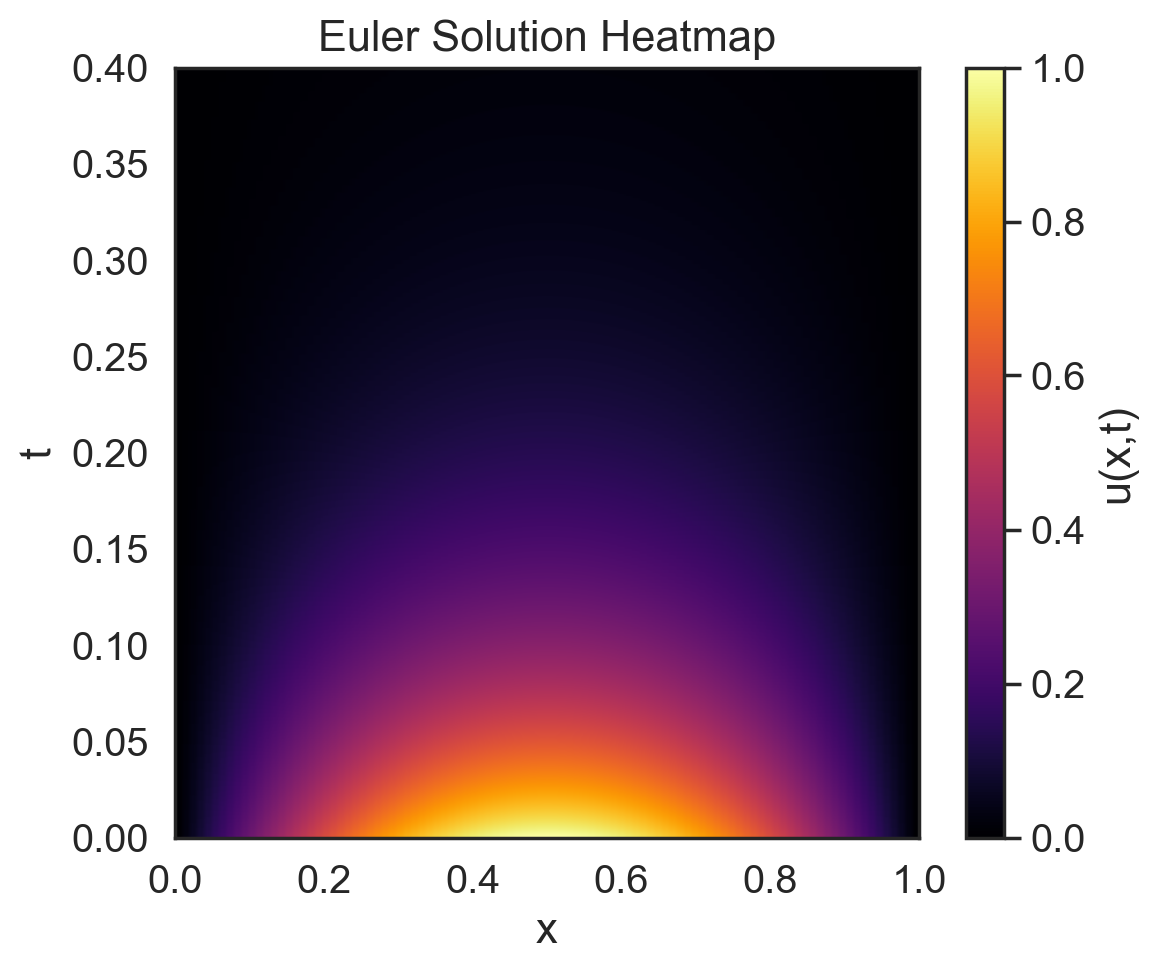

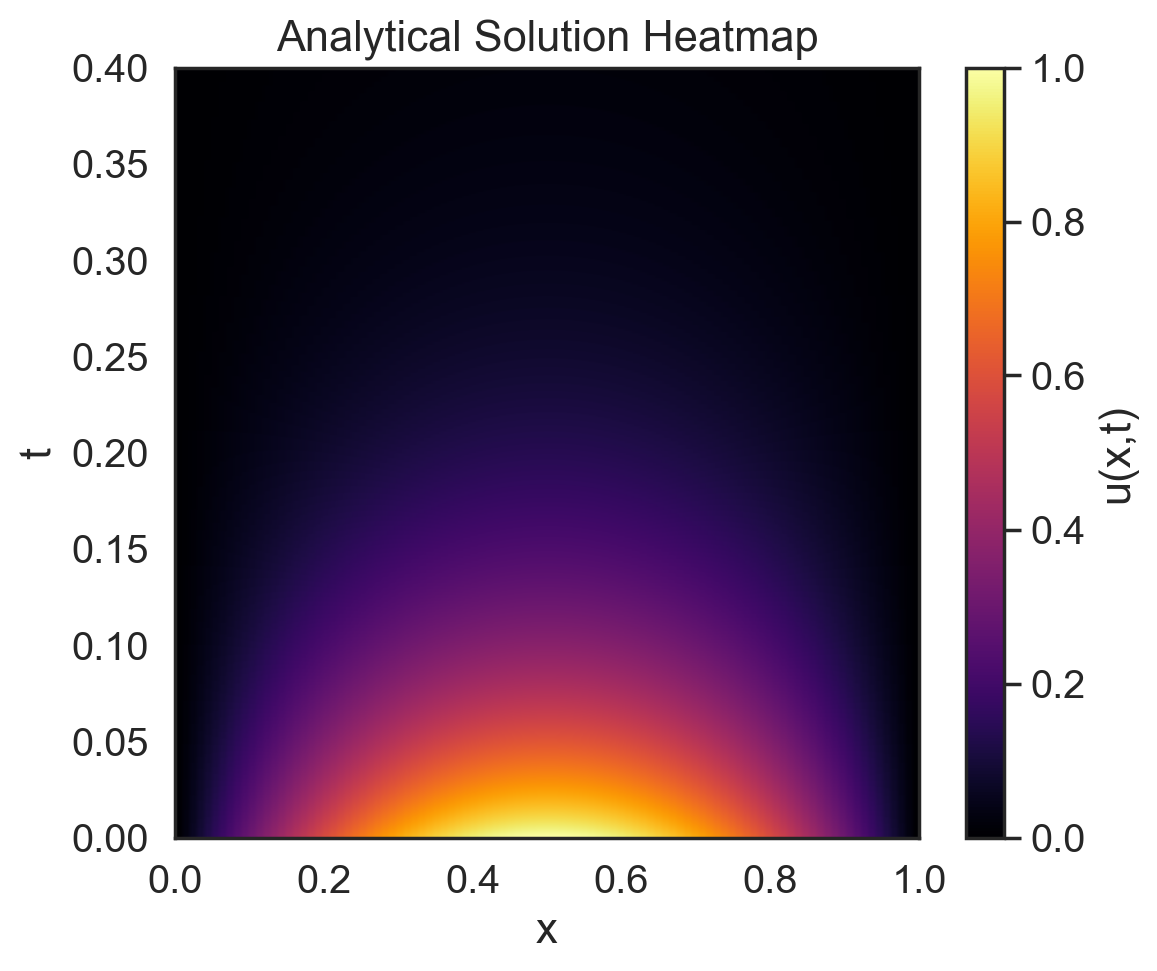

In [6]:
plt.figure(figsize=(6,5))
plt.imshow(U_exact, extent=[0,1,0,t2[-1]], origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label='u(x,t)')
plt.xlabel("x")
plt.ylabel("t")
plt.title("Euler Solution Heatmap")
plt.show()

U_exact = analytical_u(X, T)

plt.figure(figsize=(6,5))
plt.imshow(U_exact, extent=[0,1,0,t2[-1]], origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label='u(x,t)')
plt.title("Analytical Solution Heatmap")
plt.xlabel("x")
plt.ylabel("t")
plt.show()


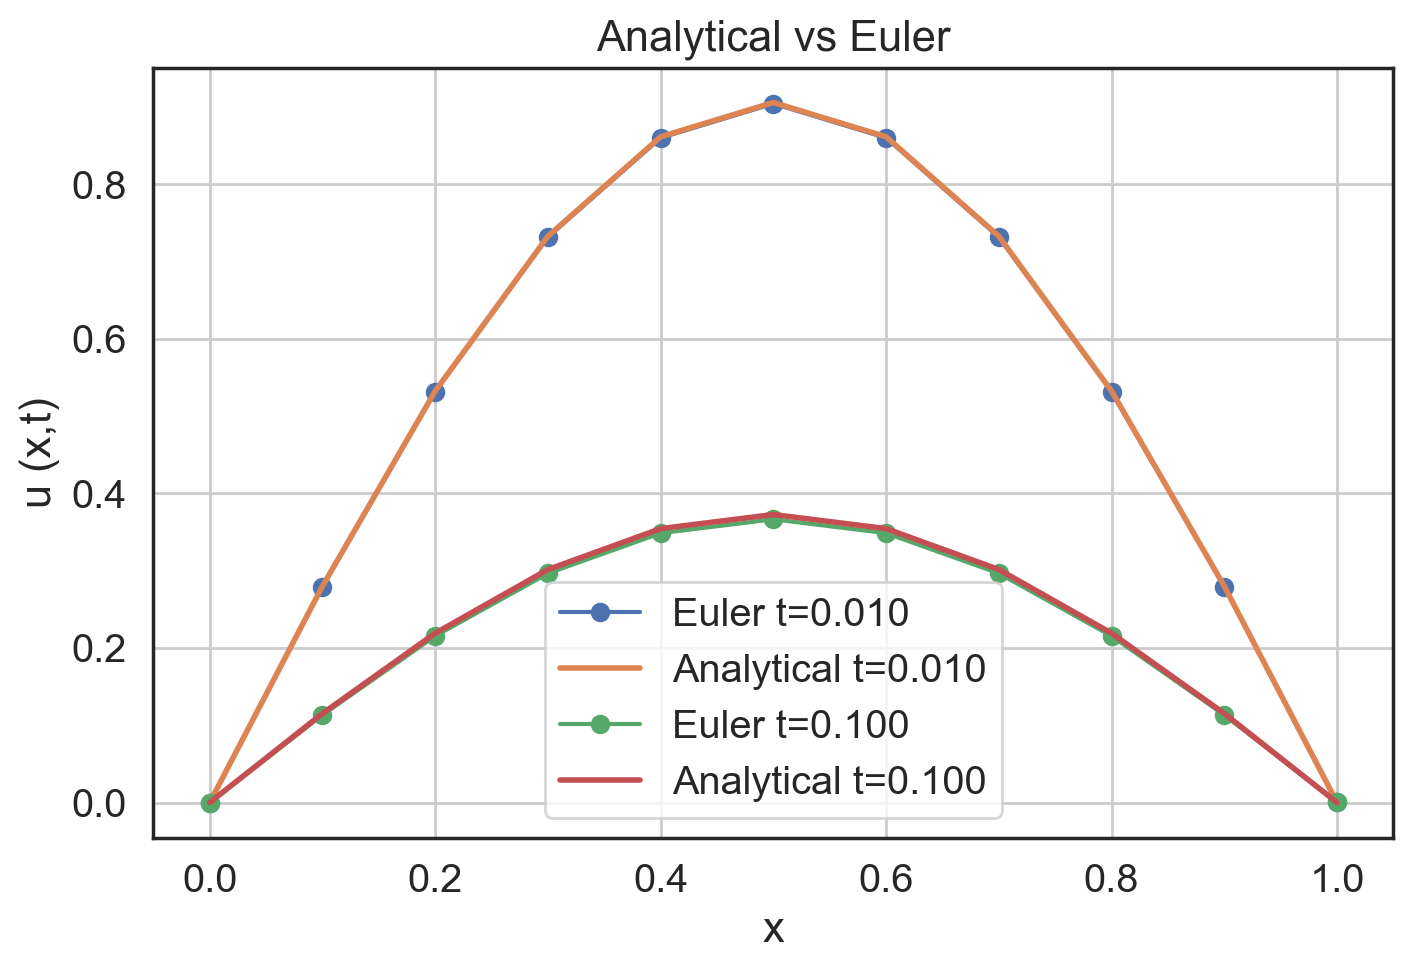

In [7]:
def compare_slices(x, U, t_grid, times):
    plt.figure(figsize=(8,5))

    for t_target in times:
        idx = np.argmin(np.abs(t_grid - t_target))
        t_val = t_grid[idx]

        plt.plot(x, U[idx], 'o-', label=f"Euler t={t_val:.3f}")
        plt.plot(x, analytical_u(x, t_val), '-', linewidth=2,
                 label=f"Analytical t={t_val:.3f}")

    plt.legend()
    plt.xlabel("x")
    plt.ylabel("u (x,t)")
    plt.grid(True)
    plt.title("Analytical vs Euler")
    plt.show()

compare_slices(x1, U1, t1, times=[0.01, 0.1])


PINN MODEL

In [8]:
NN_model = create_network_model(layers=[6, 7], activation='sigmoid')

2025-12-15 22:06:46.070739: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-15 22:06:46.070772: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-15 22:06:46.070783: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-15 22:06:46.070797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-15 22:06:46.070809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
N_points = 1000  # Number of collocation points (x, t) in the domain
epochs = 3000  # Number of training epochs
train_step = make_train_step(NN_model, optimizer, compute_loss)


T_final = 0.5 # From the analytical solution, where diffusion has spread significantly
x_samples = np.random.uniform(0.0, 1.0, N_points)
t_samples = np.random.uniform(0.0, T_final, N_points)
X_train = np.stack([x_samples, t_samples], axis=1).astype(np.float32)

# Training loop
for epoch in range(epochs):
    current_loss = train_step(X_train)

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {current_loss.numpy():.6e}")

mse = compute_MSE(NN_model, T_final=T_final)
print(f"Final MSE vs analytical: {mse:.6e}")

2025-12-15 22:06:46.593788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 500/3000, Loss: 1.975341e+00
Epoch 1000/3000, Loss: 2.895282e-01
Epoch 1500/3000, Loss: 1.031359e-01
Epoch 2000/3000, Loss: 4.983915e-02
Epoch 2500/3000, Loss: 2.613592e-02
Epoch 3000/3000, Loss: 1.488749e-02
Final MSE vs analytical: 7.216125e-06


In [10]:
# Define function to compute PINN solution at given x and t
def pinn_solution(model, x, t_value):
    X_eval = np.stack([x, np.full_like(x, t_value)], axis=1).astype(np.float32)
    X_tf = tf.constant(X_eval, dtype=tf.float32)
    N_out = model(X_tf)
    return g_trial_tf(X_tf, N_out).numpy().flatten()





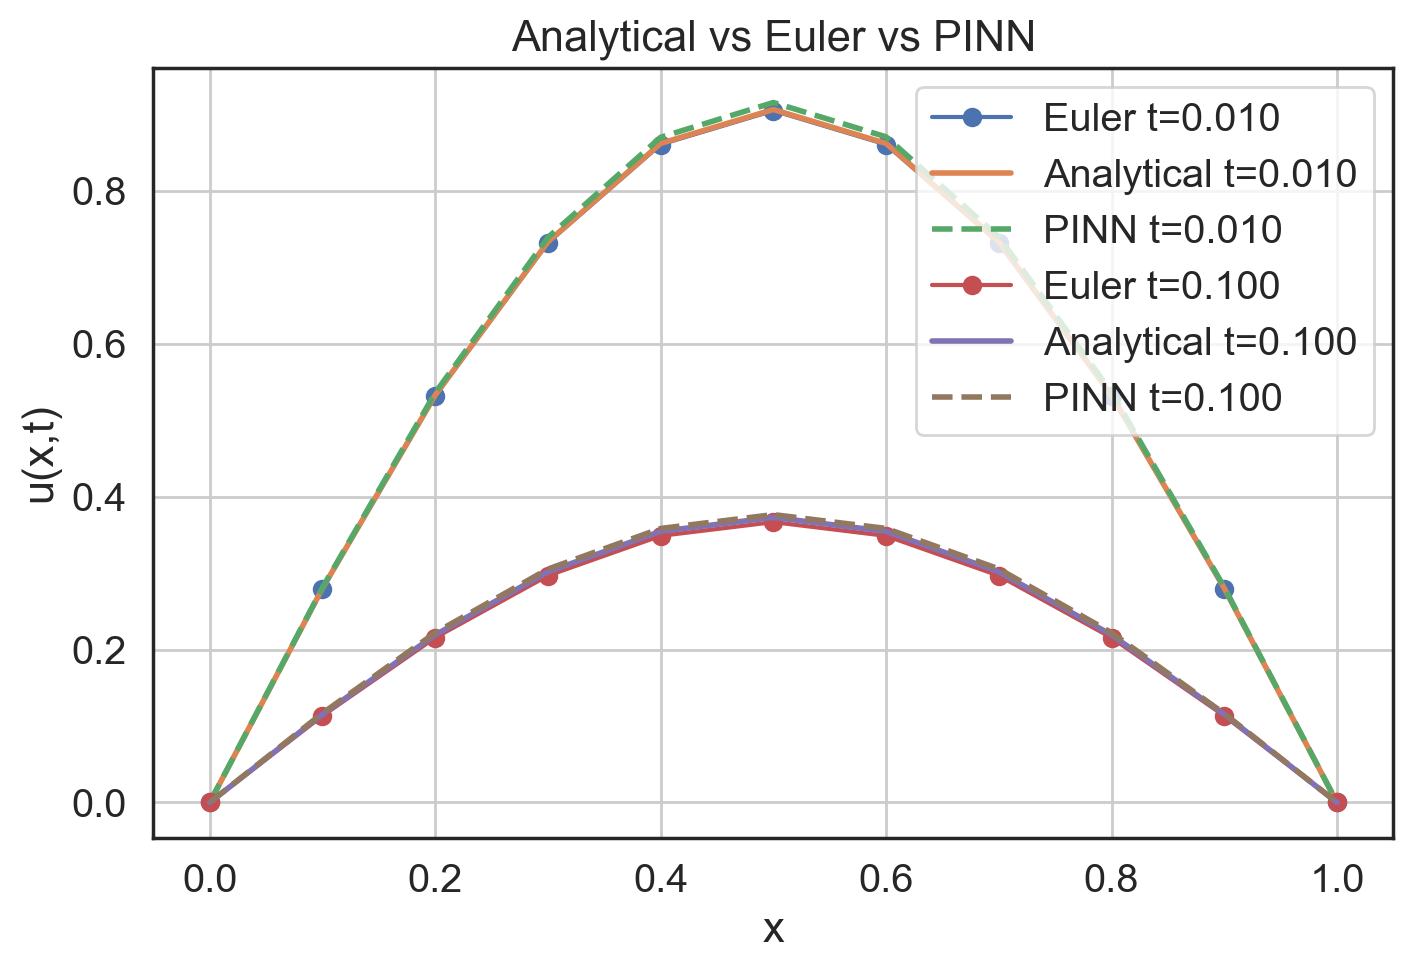

In [11]:
def compare_slices_with_pinn(x, U, t_grid, times, NN_model):
    plt.figure(figsize=(8,5))

    for t_target in times:
        idx = np.argmin(np.abs(t_grid - t_target))
        t_val = t_grid[idx]

        # Euler FD
        plt.plot(x, U[idx], 'o-', label=f"Euler t={t_val:.3f}")

        # Analytical
        plt.plot(x, analytical_u(x, t_val), '-', linewidth=2,
                 label=f"Analytical t={t_val:.3f}")

        # PINN
        u_pinn = pinn_solution(NN_model, x, t_val)
        plt.plot(x, u_pinn, '--', linewidth=2,
                 label=f"PINN t={t_val:.3f}")

    plt.legend()
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.grid(True)
    plt.title("Analytical vs Euler vs PINN")
    plt.show()

compare_slices_with_pinn(x1, U1, t1, times=[0.01, 0.1], NN_model=NN_model)


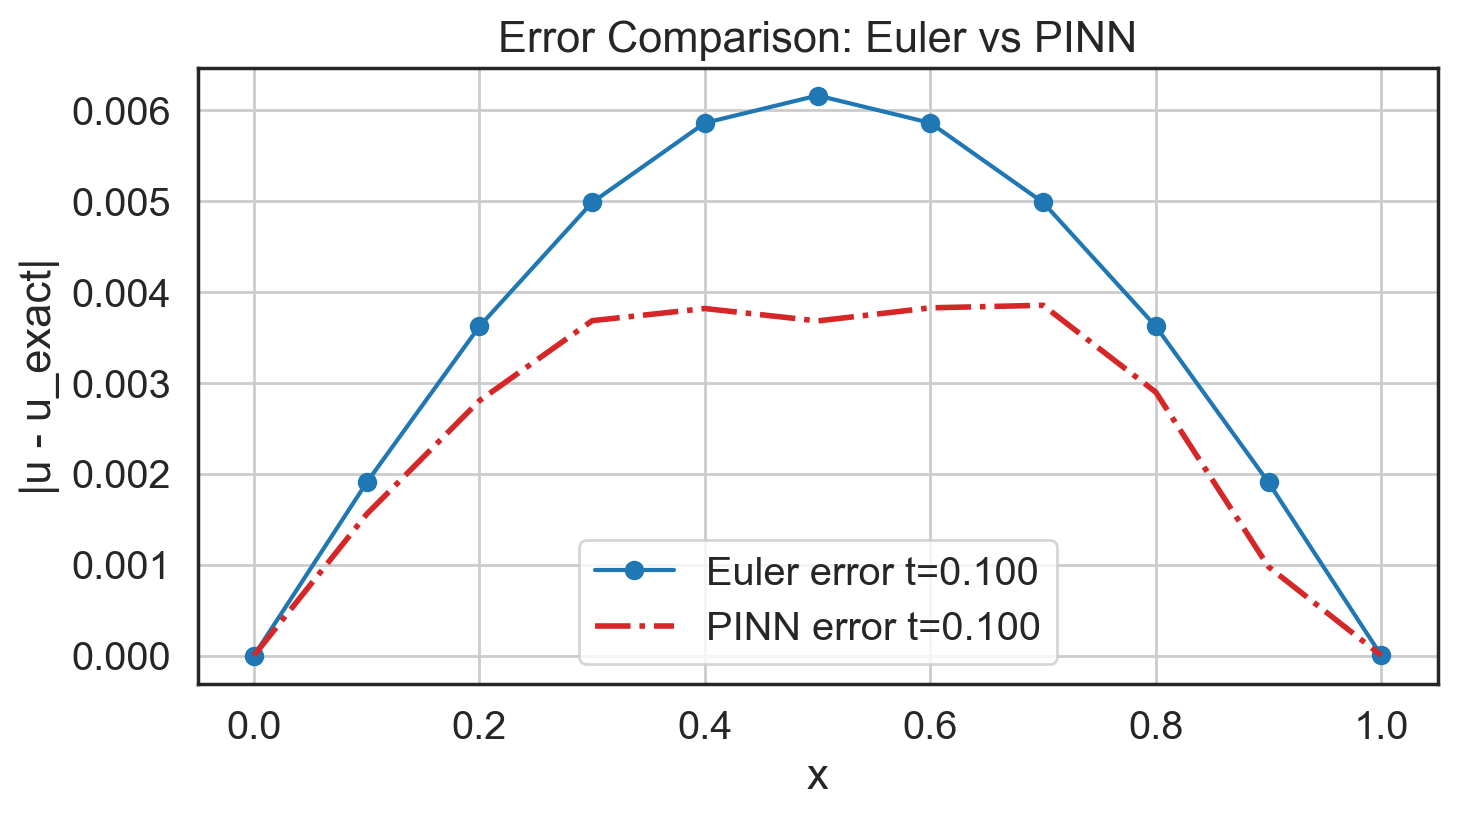

In [12]:
def plot_errors(x, U, t_grid, t_target, NN_model):
    idx = np.argmin(np.abs(t_grid - t_target))
    t_val = t_grid[idx]

    u_exact = analytical_u(x, t_val)
    u_euler = U[idx]
    u_pinn  = pinn_solution(NN_model, x, t_val)

    e_euler = np.abs(u_euler - u_exact)
    e_pinn  = np.abs(u_pinn - u_exact)

    plt.figure(figsize=(8,4))
    plt.plot(x, e_euler, 'o-', label=f"Euler error t={t_val:.3f}", color="tab:blue")
    plt.plot(x, e_pinn,  '-.', label=f"PINN error t={t_val:.3f}", color="tab:red", linewidth=2)

    plt.xlabel("x")
    plt.ylabel("|u - u_exact|")
    plt.title("Error Comparison: Euler vs PINN")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_errors(x1, U1, t1, t_target=0.1, NN_model=NN_model)


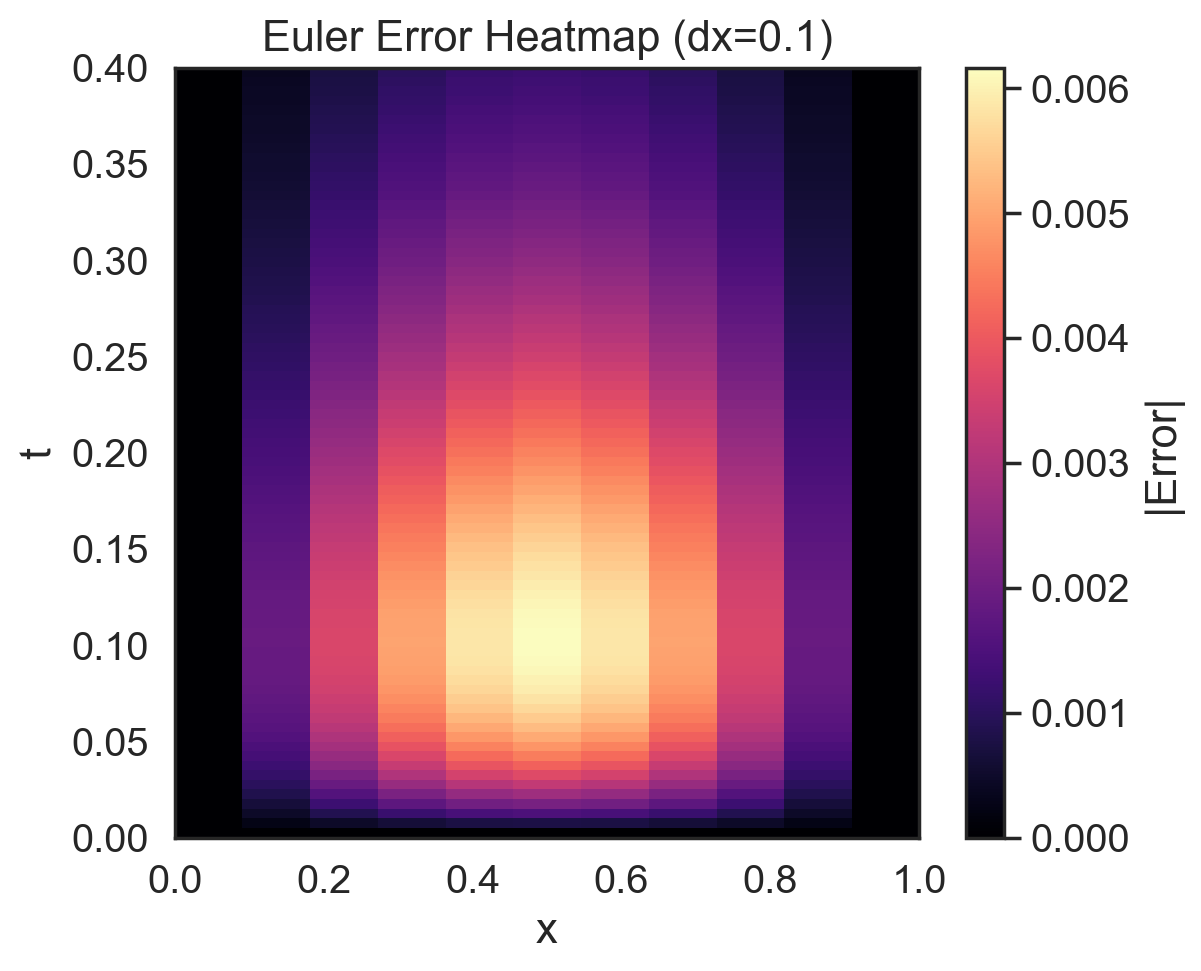

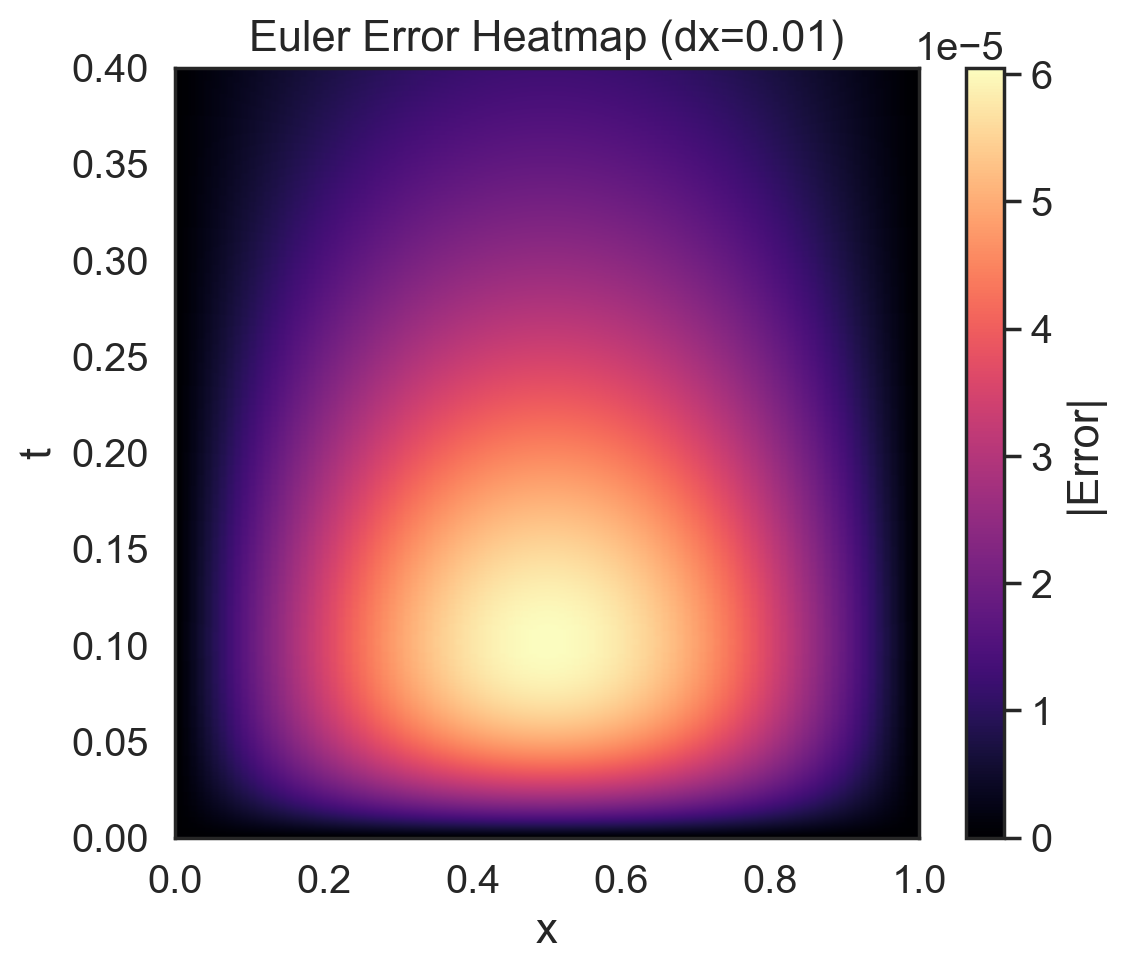

In [13]:
def heatmap_error(x, t, U, title):
    X, T = np.meshgrid(x, t)
    U_exact = analytical_u(X, T)
    error = np.abs(U - U_exact)

    plt.figure(figsize=(6,5))
    plt.imshow(error, extent=[0,1,0,t[-1]], origin='lower',
               aspect='auto', cmap='magma')
    plt.colorbar(label="|Error|")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()

heatmap_error(x1, t1, U1, "Euler Error Heatmap (dx=0.1)")
heatmap_error(x2, t2, U2, "Euler Error Heatmap (dx=0.01)")


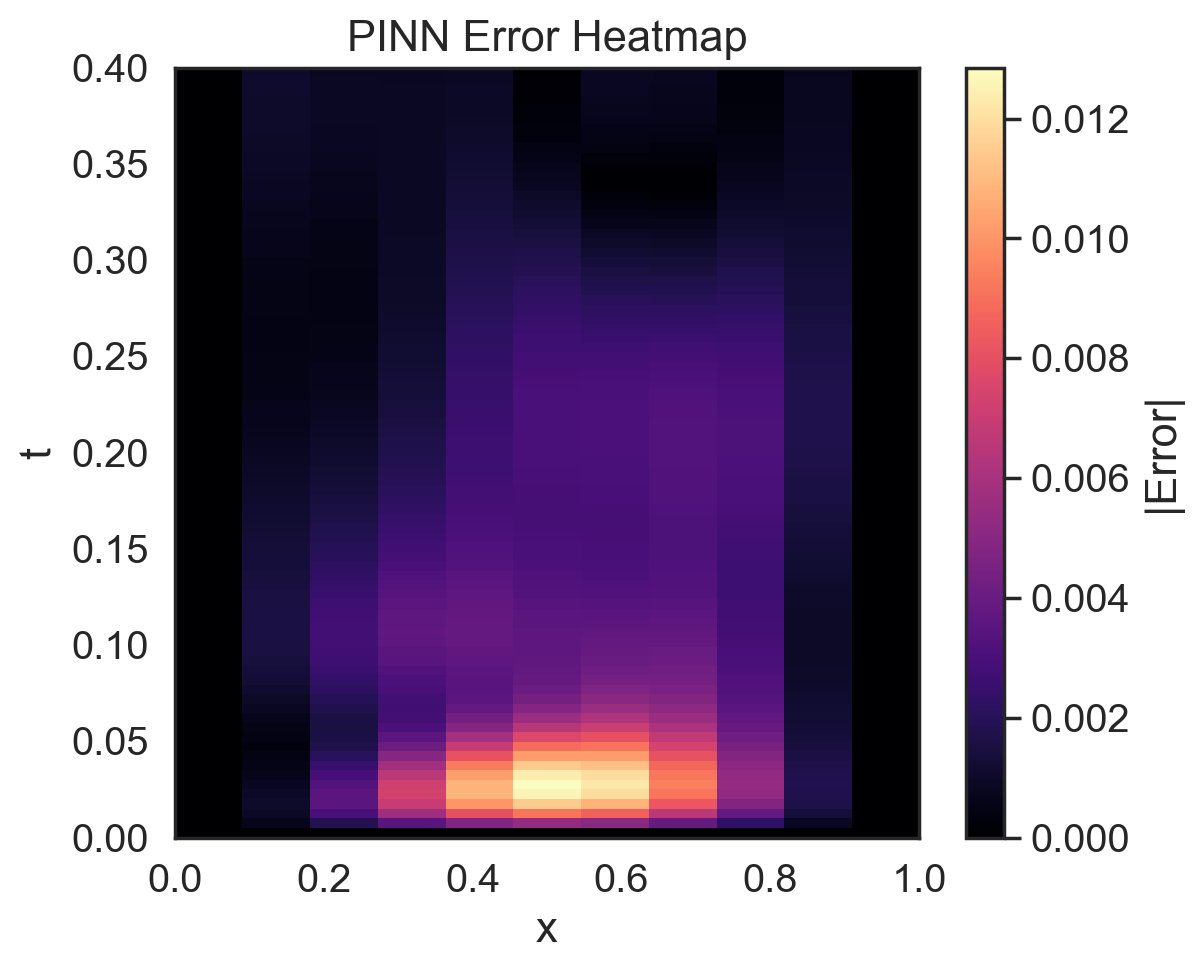

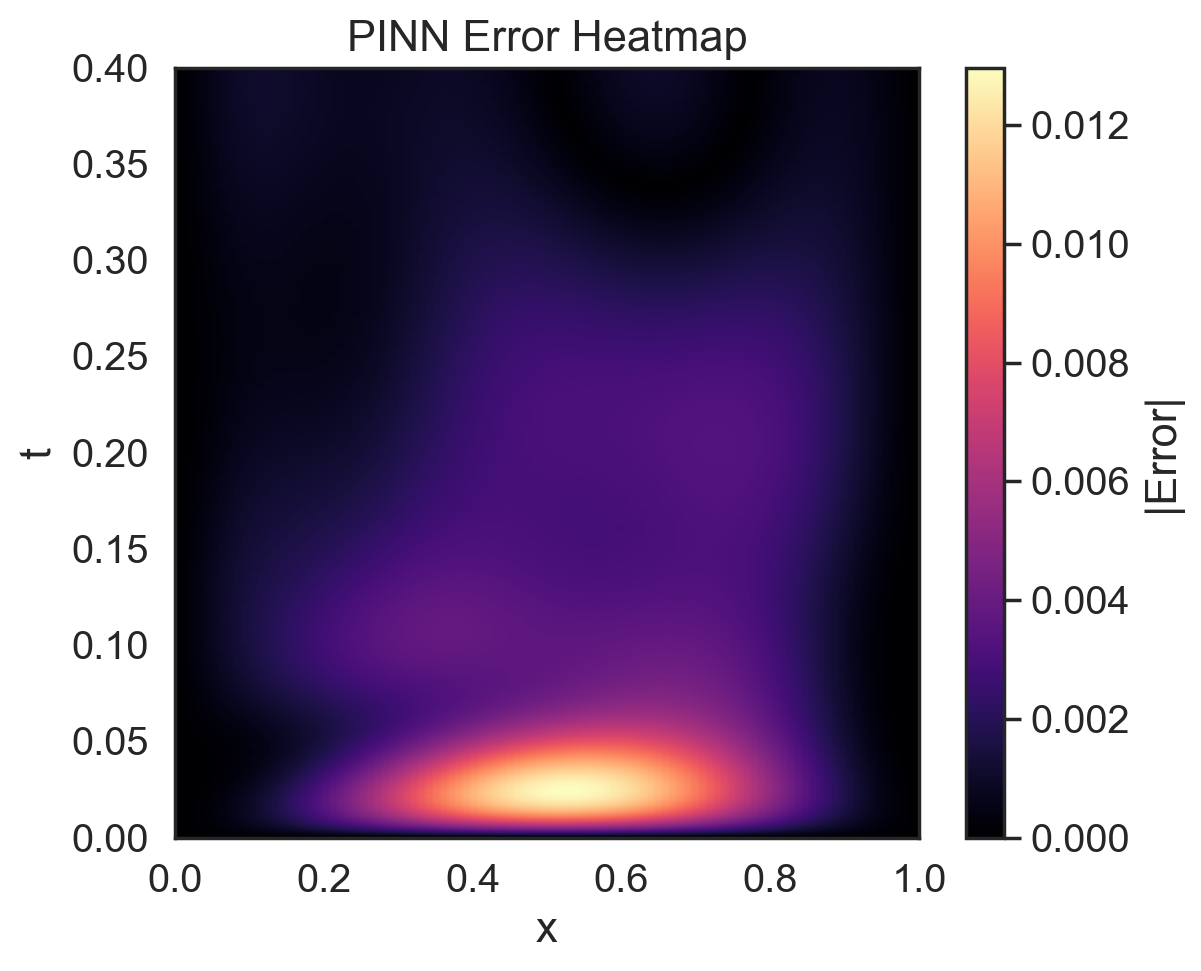

In [14]:
def pinn_error_heatmap(x, t, NN_model):
    X, T = np.meshgrid(x, t)
    U_exact = analytical_u(X, T)
    U_pinn = np.zeros_like(U_exact)

    for i, t_val in enumerate(t):
        U_pinn[i] = pinn_solution(NN_model, x, t_val)

    error = np.abs(U_pinn - U_exact)

    plt.figure(figsize=(6,5))
    plt.imshow(error, extent=[0,1,0,t[-1]], origin='lower',
               aspect='auto', cmap='magma')
    plt.colorbar(label="|Error|")
    plt.title("PINN Error Heatmap")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()


pinn_error_heatmap(x1, t1, NN_model)
pinn_error_heatmap(x2, t2, NN_model)

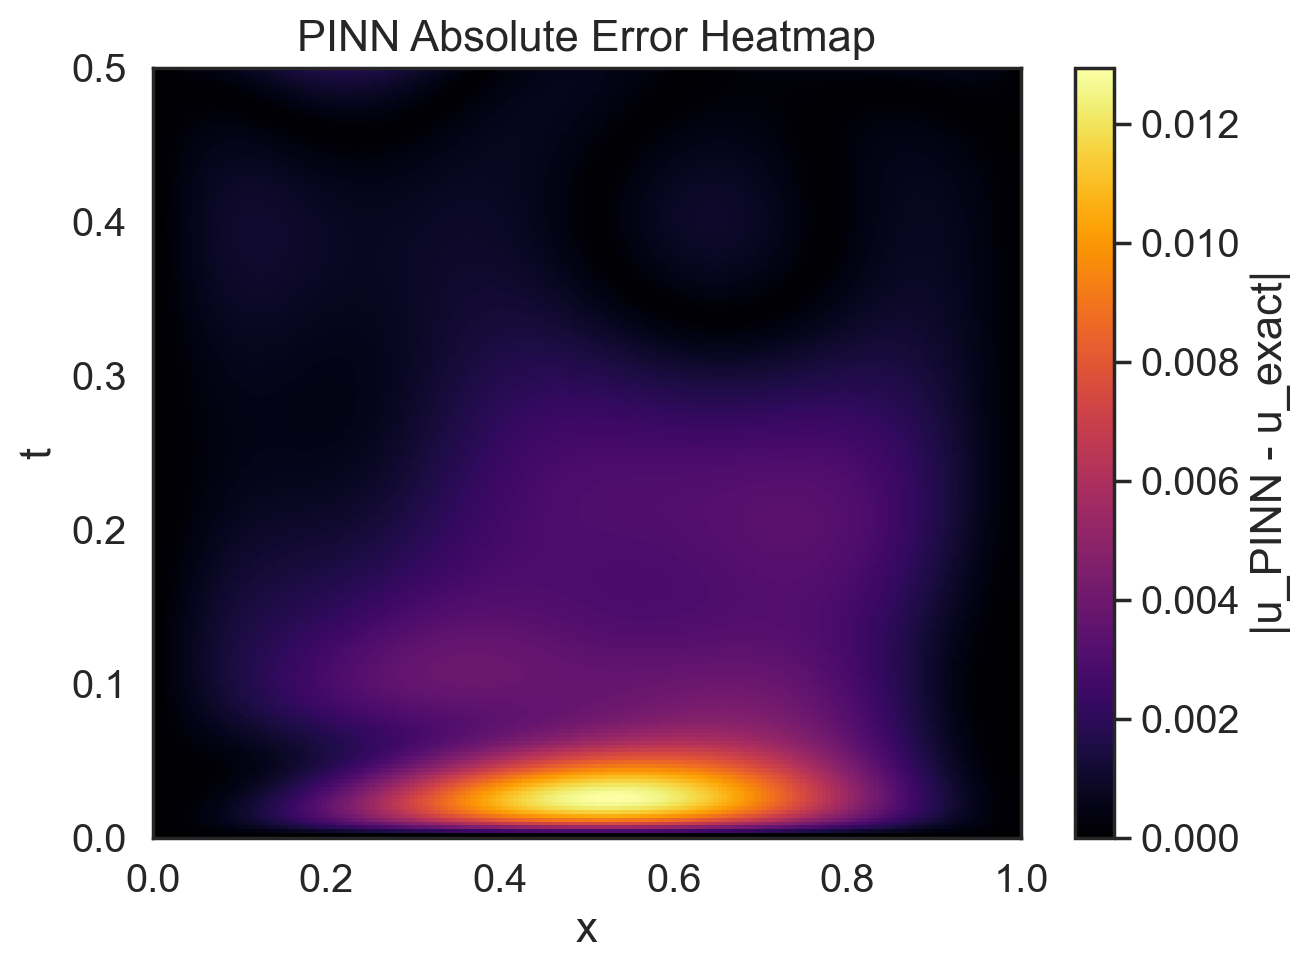

In [15]:
def pinn_error_heatmap(model, T_final=0.5, nx=200, nt=200):
    """
    Computes |u_PINN - u_exact| over a meshgrid and plots a heatmap.
    Uses pinn_solution() for each time slice.
    """

    # 1. Build the evaluation grid
    x = np.linspace(0, 1, nx)
    t = np.linspace(0, T_final, nt)

    X, T = np.meshgrid(x, t)

    # 2. Compute analytical solution
    U_exact = analytical_u(X, T)

    # 3. Compute PINN solution using your function
    U_pinn = np.zeros_like(U_exact)

    for i, t_val in enumerate(t):
        # pinn_solution returns a vector over x for fixed t
        U_pinn[i, :] = pinn_solution(model, x, t_val)

    # 4. Compute absolute error
    error = np.abs(U_pinn - U_exact)

    # 5. Plot heatmap
    plt.figure(figsize=(7, 5))
    plt.imshow(
        error,
        extent=[0, 1, 0, T_final],
        origin="lower",
        aspect="auto",
        cmap="inferno"
    )
    plt.colorbar(label="|u_PINN - u_exact|")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title("PINN Absolute Error Heatmap")
    plt.show()

    return error

error = pinn_error_heatmap(NN_model, T_final=0.5)


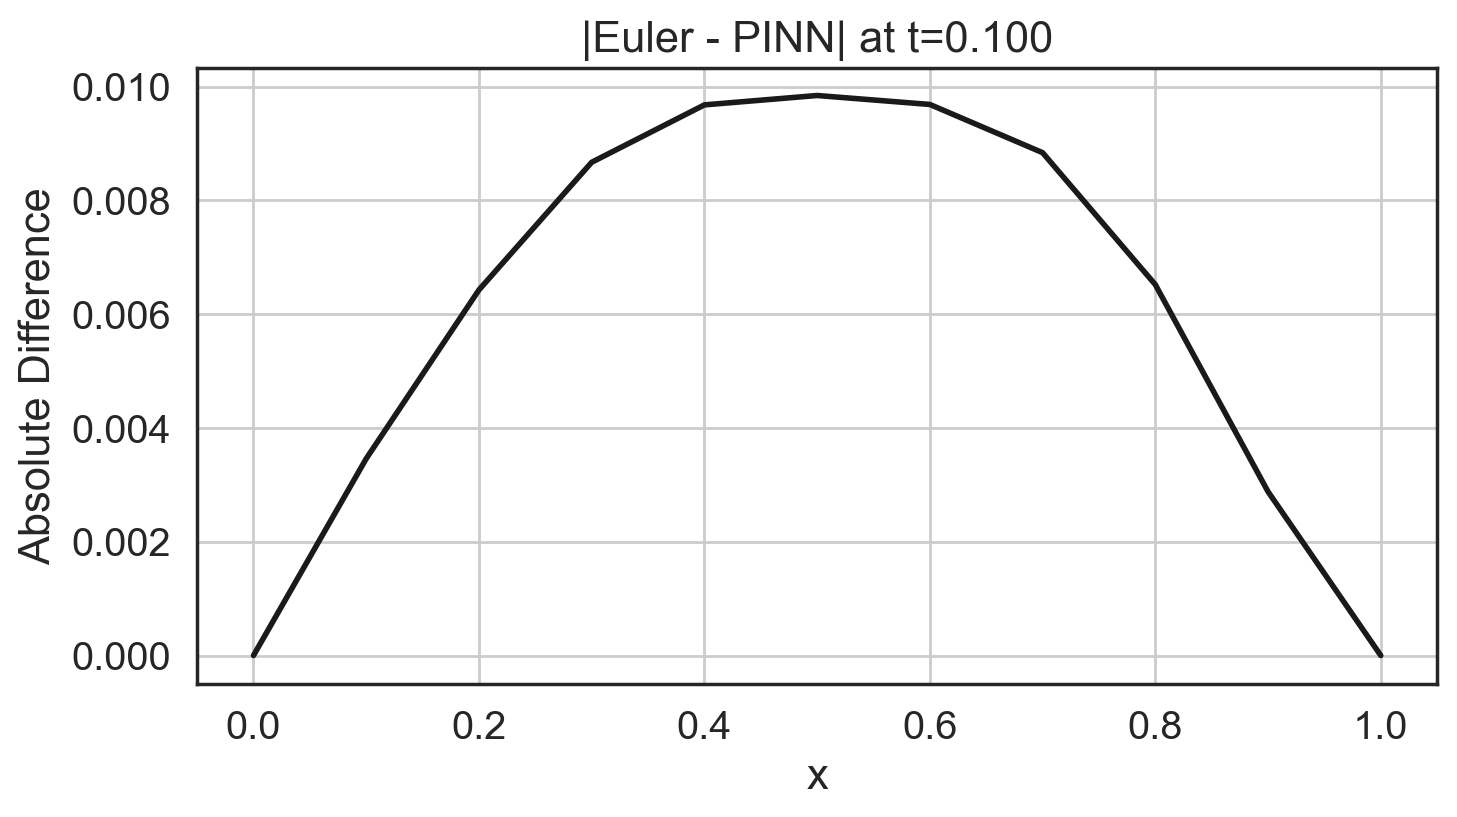

In [16]:
def compare_euler_pinn_error(x, U, t_grid, t_target, NN_model):
    idx = np.argmin(np.abs(t_grid - t_target))
    t_val = t_grid[idx]

    u_euler = U[idx]
    u_pinn  = pinn_solution(NN_model, x, t_val)

    diff = np.abs(u_euler - u_pinn)

    plt.figure(figsize=(8,4))
    plt.plot(x, diff, 'k-', linewidth=2)
    plt.title(f"|Euler - PINN| at t={t_val:.3f}")
    plt.xlabel("x")
    plt.ylabel("Absolute Difference")
    plt.grid(True)
    plt.show()

compare_euler_pinn_error(x1, U1, t1, t_target=0.1, NN_model=NN_model)

In [17]:
def plot_long_time(x, U, t_grid, t_target, NN_model):
    idx = np.argmin(np.abs(t_grid - t_target))
    t_val = t_grid[idx]

    # Solutions
    u_exact = analytical_u(x, t_val)
    u_euler = U[idx]
    u_pinn  = pinn_solution(NN_model, x, t_val)

    # Plot
    plt.figure(figsize=(7,4))
    plt.plot(x, u_exact, 'k-', lw=2, label=f"Analytical t={t_val:.3f}")
    plt.plot(x, u_euler, 'o-', lw=1.5, label=f"Euler t={t_val:.3f}")
    plt.plot(x, u_pinn, '--', lw=2, label=f"PINN t={t_val:.3f}")

    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title("Long-Time Comparison: Euler vs PINN vs Analytical")
    plt.grid(True)
    plt.legend()
    plt.show()


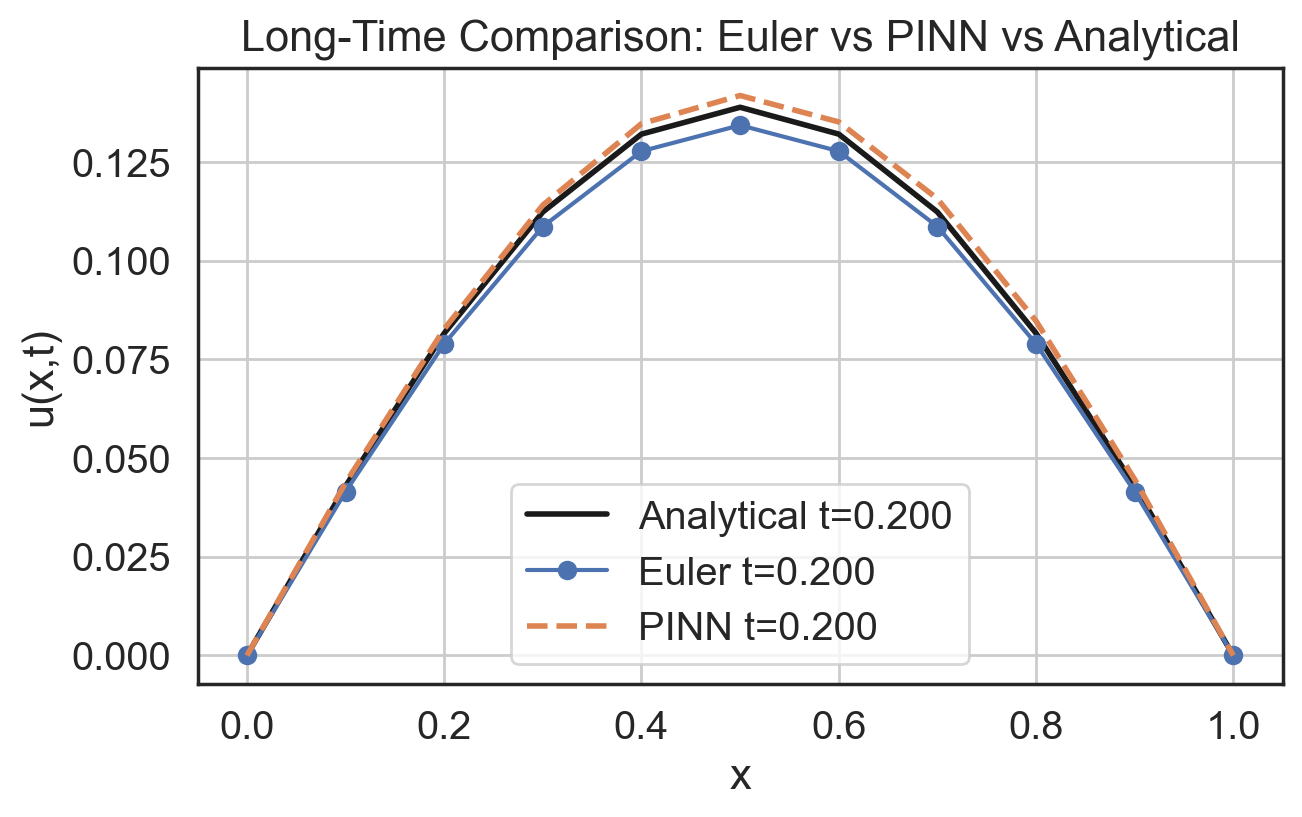

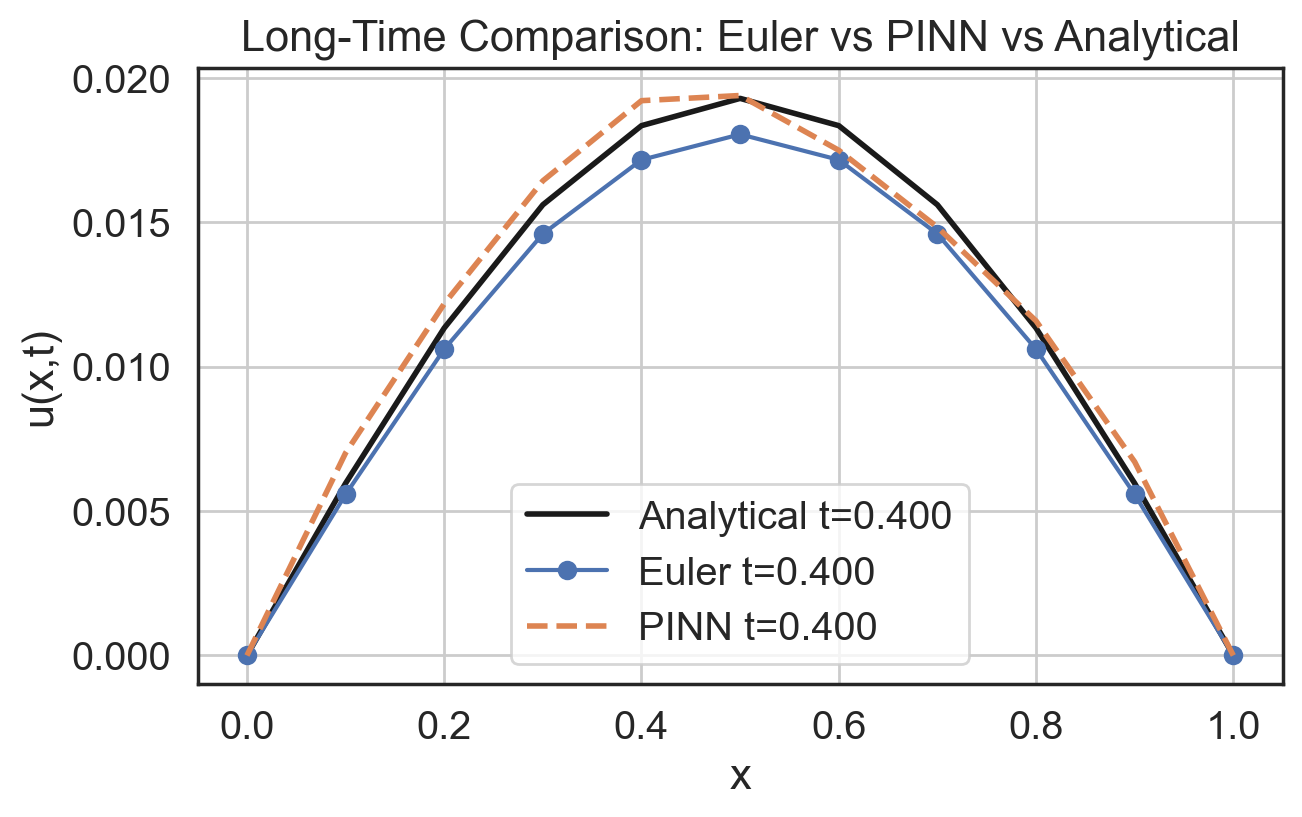

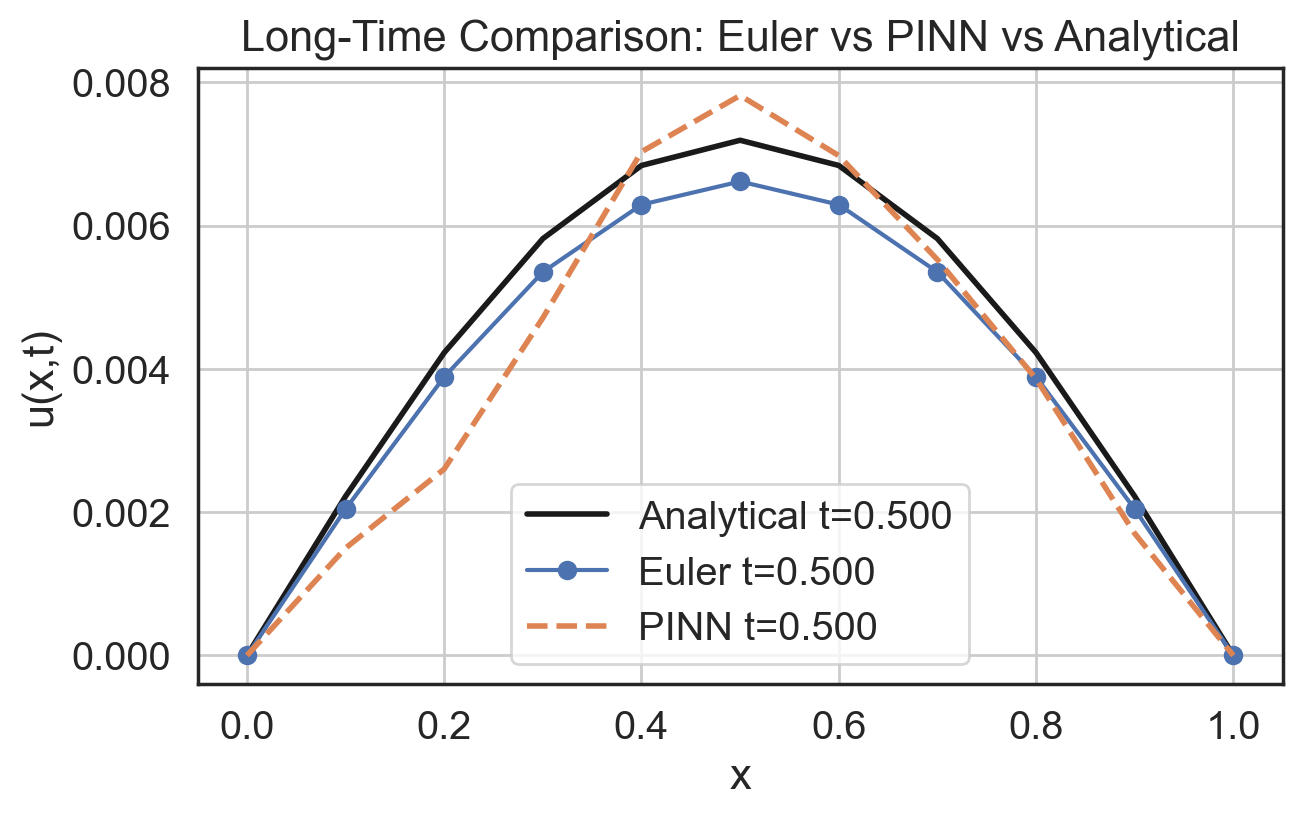

In [18]:
x1, t1, U1 = euler(dx1, dt1, T=0.5)

plot_long_time(x1, U1, t1, t_target=0.2, NN_model=NN_model)
plot_long_time(x1, U1, t1, t_target=0.4, NN_model=NN_model)
plot_long_time(x1, U1, t1, t_target=0.5, NN_model=NN_model)